# [Tutorial](https://quantpy.com.au/weather-derivatives/de-trending-and-modelling-seasonal-variation-with-fourier-series/)

--- 
# <center>De-trending and modelling seasonal variation with Fourier Series</center>

## Time series decomposition is a technique that splits a time series into several components, each representing an underlying pattern category, trend, seasonality, and noise. 

### <center>$y_{t} = T_{t} + S_{t} + e_{t}$</center>

- ### 1. Trend: decreasing, constant, or increasing over time?

- ### 2. Seasonality: what is the periodic signal?

- ### 3. Noise: variability in the data that cannot be explained by the model


### The model (in terms of T for temperature) for deterministic seasonal mean temperature: 

### <center>$\bar{T_{t}} = T_{trend} + T_{seasonal}$</center>

## We will be using the first-order fourier series, and use non-linear least-squared regression  to be able to estimate parameters of the model. 

---
### Daily Average Temperature Series from Sydney Observatory, 1-Jan-1859 to Jul 2022

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from scipy import signal
import matplotlib.pyplot as plt

- ### Read in the data (saved from 02_Statistical_Analysis_of_Temperature_Data.ipynb)

In [2]:
temps = pd.read_csv('Sydney_Observatory_Tmax_Tmin_T_185901-202207.csv', index_col = 'Date')
temps

,Tmax,Tmin,T
Date,,,
1859-01-01,24.4,14.5,19.45
1859-01-02,24.4,15.7,20.05
1859-01-03,24.2,15.3,19.75
1859-01-04,24.7,17.4,21.05
1859-01-05,24.6,16.9,20.75
...,...,...,...
2022-06-29,17.9,8.0,12.95
2022-06-30,16.9,10.2,13.55
2022-07-01,12.0,10.3,11.15


- ### Visualization of the last 25 years data

- ### To do: fix the x-labels

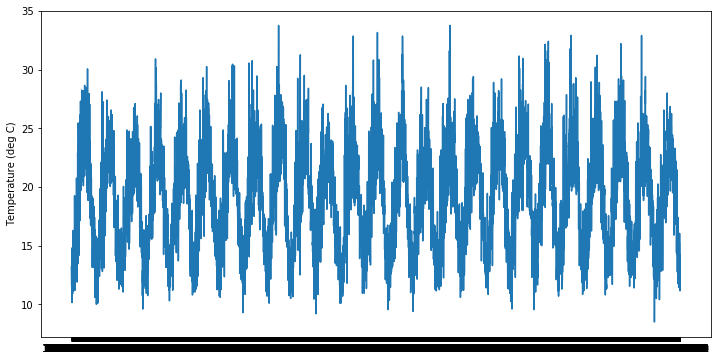

In [3]:
lookback = 365 * 25
fig = plt.figure(figsize=(12, 6))
plt.plot(temps['T'][-lookback:])
plt.ylabel('Temperature (deg C)')
plt.show()

## Denoise the daily average temperature series

- ### Let's remove the noise to see trend and overall peaks. 

A simple algorithm that is used frequently in the signal processing industry for this purpose are `Convolutions`

A `Convolution` is a mathmatical operation which generates a new function that is a function of two prior functions, meaning the convolution is the area under the curve of the two functions which are moved towards and away from one another (`'convolved'`). 


### <center>$(f * g)(x) = \int_{-\infty}^{\infty} f(\tau)\ g(x - \tau)\ d\tau\$</center>

## Applied convolution 

- ### We use a square function to convolve over our temperature series

- ### Below is a visualizaiton of how does the square function looks like

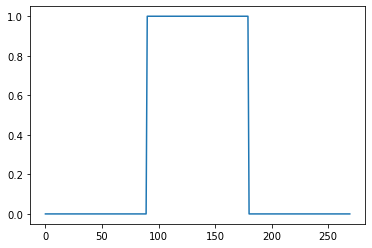

In [4]:
conv = np.repeat([0., 1., 0.], 90)
plt.plot(conv)

- ### Define `apply_convolution` and apply to our temperature series

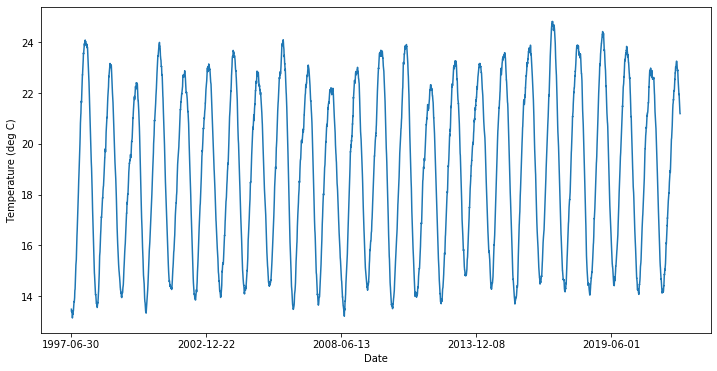

In [5]:
def apply_convolution(x, window):
    conv = np.repeat([0., 1., 0.], window)
    filtered = signal.convolve(x, conv, mode='same') / window
    return filtered 

denoised = temps.apply(lambda x: apply_convolution(x, 90))
denoised['T'][-lookback:-100].plot(figsize=(12,6))
plt.ylabel('Temperature (deg C)')
plt.show()

## Longterm trend



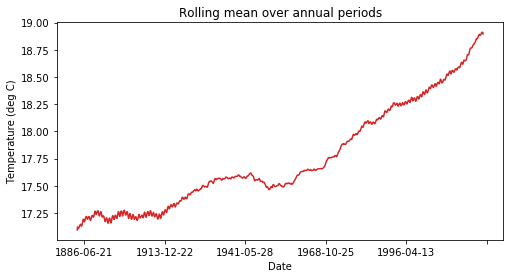

In [6]:
denoised['MA'] = denoised['T'].rolling(window = lookback).mean()
plt.ylabel('Temperature (deg C)')
denoised['MA'].plot(figsize=(8,4), color='tab:red', title='Rolling mean over annual periods')

- ### By observing the rolling moving average over time, we noticed that there is a clear but weak trend over time. 

- ### Therefore we will simply use the following linear function. 

### <center>$T_{linear} = a + bt$</center>

## Seasonal Variation 


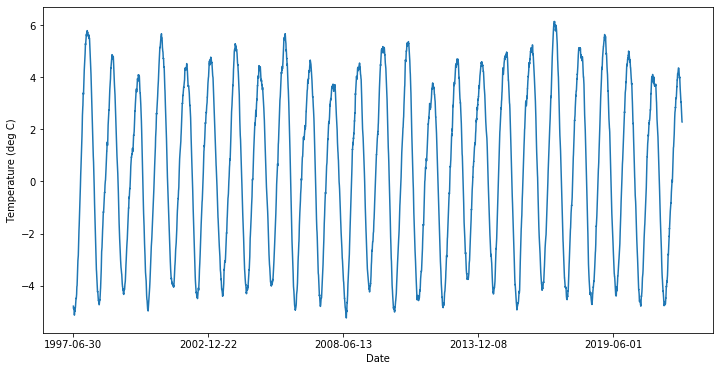

In [7]:
denoised['S'] = denoised['T'] - denoised['MA']
denoised['S'][-lookback:-100].plot(figsize=(12,6))
plt.ylabel('Temperature (deg C)')
plt.show()

- ### The `detrended and denoised` temperature time series reveals that temperatures have somewhat uniform peaks. 

- ### We will model the seasonal variation via a `truncated Fourier series` of form:

### <center>$T_{seasonal} = a_{0} + \sum_{i} \alpha_{i} \sin(i\omega_{1}t + \theta) + \sum_{i} \beta_{i} \cos(i\omega_{2}t + \phi)$</center>

- ### The good news is that many papers (see references at the end) suggest that the temperature seasonal variation can be captured by the first order Fourier series. 

### <center>$T_{seasonal} = \alpha \sin(\omega t + \theta) + \beta \cos(\omega t + \phi)$</center>

- ### One paper (Tindall, 2006) used a simplied representation of a single sine function (we will compare the two)

### <center>$T_{seasonal} = \alpha \sin(\omega t + \theta)$</center>

### <center>$T_{seasonal} = \alpha \sin(\theta)\cos(\omega t) + \alpha \cos(\theta)\sin(\omega t)$</center>

### Defining $a_{1} = \alpha \sin(\theta)$ and $b_{1} = \alpha \cos(\theta)$, we can rewrite this as:

### <center>$T_{seasonal} = a_{1}\cos(\omega t) + b_{1} \sin(\omega t)$</center>, where

   - ### $\alpha = \sqrt{a_{1}^{2} + b_{1}^{2}}$ 
    
   - ### and because $\tan(\theta) = \frac{a_{1}}{b_{1}}$, $\theta = \tan^{-1}(\frac{a_{1}}{b_{1}})$
    
### Note that we assume:

   - ### $a_{0}$ will be captured in the trend component 
    
   - ### the `speeds` of the seasonal processes are the same at $\omega = \frac{2\pi}{365}$

---
## De-trended & Seasonality Removed 

- ### So the deterministic seasonal mean, the denoised time series is modelled like:

### <center>$\bar{T_{t}} = T_{trend} + T_{seasonal}$</center>

- ### Test and compare two models:

    - ### 1. $\bar{T_{t}} = a + bt + \alpha \sin(\omega t + \theta) + \beta \cos(\omega t + \phi)$

    - ### 2. $\bar{T_{t} = a + bt + \alpha \sin(\omega t + \theta)}$

- ### Check out [this link](https://stackoverflow.com/questions/23004374/how-to-calculate-the-likelihood-of-curve-fitting-in-scipy) if you want to compare non-linear model fits

## Model Fitting: Non-linear Least Squares

- ### Here we use `scipy.optimize.curve_fit` which implements the `Levenberg-Marquardt algorithm (LMA)`

- ### This is used in `non-linear least squares problems` and combines both the `Gauss-Newton algorithm (GNA)` and `gradient descent methods`

### <center>$\hat{\beta} \in argmin_{\beta}S(\beta) \equiv argmin_{\beta} \sum_{i-1}^{N} [y_{i} - f(x_i, \beta)]^{2}$</center>

In [8]:
from scipy.stats import norm
from scipy.optimize import curve_fit

temp_t = temps['T'].copy(deep=True)
temp_t = temp_t.to_frame()

In [9]:
def model_fit_general(x, a, b, a1, b1, theta, phi):
    omega = 2 * np.pi / 365 # 365.25
    
    y_pred = a + b * x + a1 * np.cos(omega * x + theta) + b1 * np.sin(omega * x + phi)
    
    return y_pred

def model_fit(x, a, b, a1, b1):
    omega = 2 * np.pi / 365 # 365.25
    
    y_pred = a + b * x + a1 * np.cos(omega * x) + b1 * np.sin(omega * x)
    
    return y_pred

def RSS(y, y_pred):
    return np.sqrt((y - y_pred) **2).sum()

In [11]:
if isinstance(temp_t.index, pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index = temp_t.index.map(dt.datetime.toordinal)
else:
    temp_t.index = pd.to_datetime(temp_t.index)
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index = temp_t.index.map(dt.datetime.toordinal)
    
params, cov = curve_fit(model_fit, xdata = temp_t.index-first_ord, ydata = temp_t['T'], method = 'lm')

param_list = ['a', 'b', 'a1', 'b1']

print('\n Model fit \n')
std_dev = np.sqrt(np.diag(cov))

for name, p, sd in zip(param_list, params, std_dev):
    print('{0}: {1:0.3} CI ~normally [{2:0.2e}, {3:0.2e}]'.format(name, p, p-1.96*sd, p+1.96*sd))
    
temp_t['model_fit'] = model_fit(temp_t.index-first_ord, *params)


 Model fit 

a: 16.8 CI ~normally [1.68e+01, 1.68e+01]
b: 3.35e-05 CI ~normally [3.23e-05, 3.46e-05]
a1: 3.92 CI ~normally [3.89e+00, 3.95e+00]
b1: 3.0 CI ~normally [2.97e+00, 3.02e+00]


In [12]:
temp_t.index

Int64Index([678621, 678622, 678623, 678624, 678625, 678626, 678627, 678628,
            678629, 678630,
            ...
            738330, 738331, 738332, 738333, 738334, 738335, 738336, 738337,
            738338, 738339],
           dtype='int64', name='Date', length=59557)

In [13]:
#if isinstance(temp_t.index, pd.DatetimeIndex):
#    temp_t.index=temp_t.index.map(dt.datetime.toordinal)
#else:
#    temp_t.index=temp_t.index.map(dt.datetime.fromordinal)
#else:
#    temp_t.index=pd.to_datetime(temp_t.index)
#    temp_t.index=temp_t.index.map(dt.datetime.toordinal)
    
params1, cov1 = curve_fit(model_fit_general, xdata=temp_t.index-first_ord , ydata=temp_t['T'], method='lm')

param_list = ['a', 'b', 'a1', 'b1', 'theta', 'phi']

print('\n Model fit general \n')
std_dev = np.sqrt(np.diag(cov1))

for name, p, sd in zip(param_list, params1, std_dev):
    print('{0}: {1:0.3} CI ~normally [{2:0.2e}, {3:0.2e}]'.format(name, p, p-1.96*sd, p+1.96*sd))
    
temp_t['model_fit_general'] = model_fit_general(temp_t.index-first_ord, *params1)


 Model fit general 

a: 16.8 CI ~normally [1.68e+01, 1.68e+01]
b: 3.35e-05 CI ~normally [3.23e-05, 3.46e-05]
a1: -1.26e+02 CI ~normally [-6.08e+06, 6.08e+06]
b1: 1.31e+02 CI ~normally [-6.08e+06, 6.08e+06]
theta: 1.06e+02 CI ~normally [-6.12e+03, 6.33e+03]
phi: 2.21e+02 CI ~normally [-5.77e+03, 6.21e+03]


Residual Sum of Squares (RSS)
  RSS model generalised:  112295.88
  RSS model sine curve:  112295.89


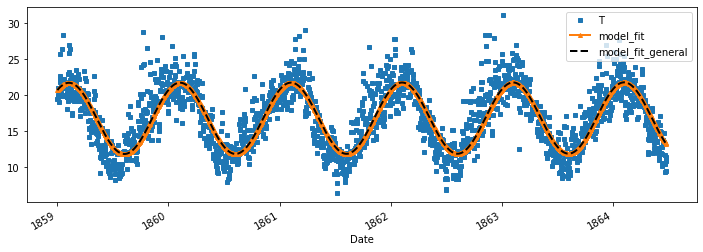

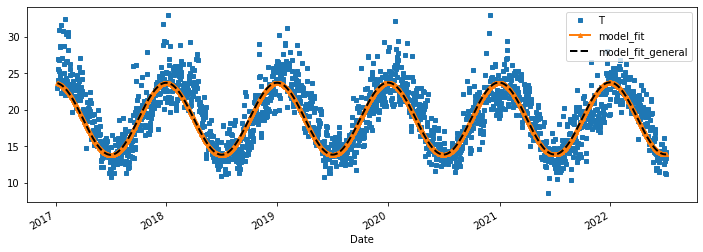

In [14]:
if not isinstance(temp_t.index, pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(dt.datetime.fromordinal)
    
temp_t[:2000].plot(figsize=(12, 4), style=['s', '^-', 'k--'], markersize=4, linewidth = 2)
temp_t[-2000:].plot(figsize=(12, 4), style=['s', '^-', 'k--'], markersize=4, linewidth = 2)

RSS(temp_t['T'], temp_t['model_fit_general'])
print('Residual Sum of Squares (RSS)')
print('  RSS model generalised: ', round(RSS(temp_t['T'], temp_t['model_fit_general']), 2))
print('  RSS model sine curve: ', round(RSS(temp_t['T'], temp_t['model_fit']), 2))

### Notes:

- ### Both models are equivalent, so we choose the simple one with less tuned parameters, aiming for parsimony. 

- ### There does seem to be an issue with the leading and lagging phase shifts between the 160 year intervals. This was identified as the incorrect frequency assumption of 365 days a year. 

- ### Over approximately 160 years, the phase shift occurs leap years adding up to approximately 40 days. 

- ### We remade the assumption: the speeds of the seasonal processes are the same at $\omega = \frac{2\pi}{365.25}$

Parameters:
     a 16.8
      b 3.32e-05
    alpha 5.05
     theta 1.27


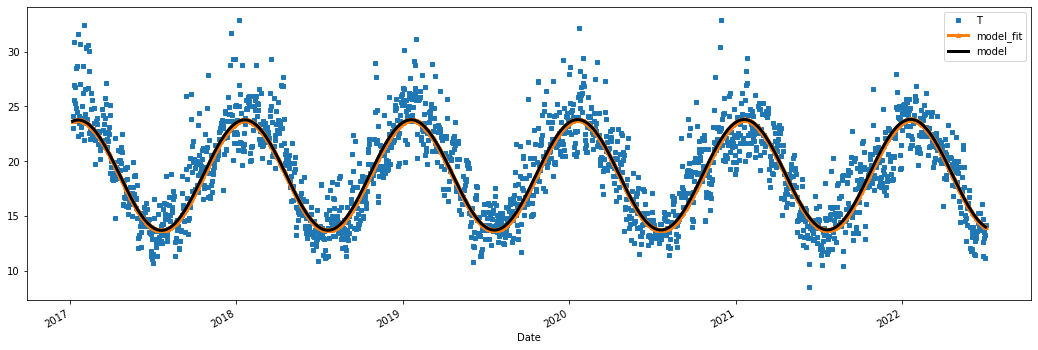

In [18]:
temp_t = temps['T'].copy(deep=True)
temp_t = temp_t.to_frame()

def model(x, params):
    a,b,a1,b1 = params
    omega = 2 * np.pi/365.25
    theta = np.arctan(a1/b1)
    alpha = np.sqrt(a1 ** 2 + b1 ** 2)
    print('Parameters:\n     a {0:0.3}\n      b {1:0.3}\n    alpha {2:0.3}\n     theta {3:0.3}'.format(a,b,alpha,theta))
    y_pred= a + b * x + alpha * np.sin(omega * x + theta)
    return y_pred
    
def model_fit(x, a, b, a1, b1):
    omega = 2 * np.pi / 365.25
    y_pred = a + b * x + a1 * np.cos(omega * x) + b1 * np.sin(omega * x)
    return y_pred

if isinstance(temp_t.index , pd.DatetimeIndex):
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index=temp_t.index.map(dt.datetime.toordinal)
else: 
    temp_t.index = pd.to_datetime(temp_t.index)
    first_ord = temp_t.index.map(dt.datetime.toordinal)[0]
    temp_t.index = temp_t.index.map(dt.datetime.toordinal)

params_fit, cov = curve_fit(model_fit, xdata=temp_t.index-first_ord, ydata = temp_t['T'], method = 'lm')
temp_t['model_fit'] = model_fit(temp_t.index-first_ord, *params_fit)

params_all, cov = curve_fit(model_fit, xdata=temp_t.index-first_ord, ydata=temp_t['T'], method='lm')
temp_t['model'] = model(temp_t.index-first_ord, params_all)

if not isinstance(temp_t.index , pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(dt.datetime.fromordinal)
    
temp_t[-2000:].plot(figsize=(18,6), style=['s','^-','k-'] , markersize=4, linewidth=3)

---
## Our Model for the trend and seasonality 

### This is our changing average of daily averaged temperature

### <center>$\bar{T_{t}} = a + bt + \alpha \sin(\omega t + \theta)$</center>

### where our changing average of daily average temperature $\bar{T_{t}}$ is:

### <center>$\bar{T_{t}} = 16.8 + (3.32^{-5})t + 5.05\sin((\frac{2\pi}{365.25})t + 1.27)$</center>

### where the date 01-Jan-1859 corresponds with the first ordinal number 0. 

---
## Take a look at the Residuals

- ### Now we have obtained our deterministic seasonal time series 

- ### We take a look at the residuals after detrending and removing seasonality

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

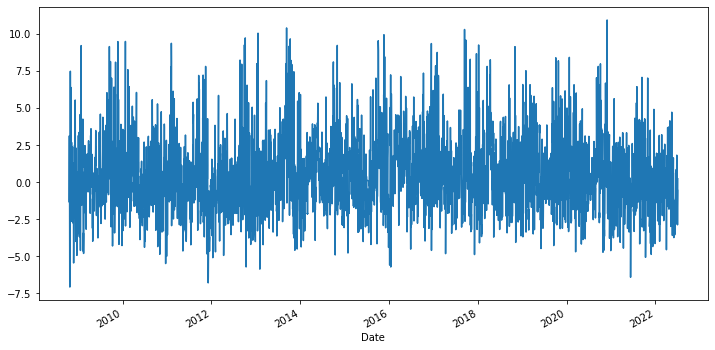

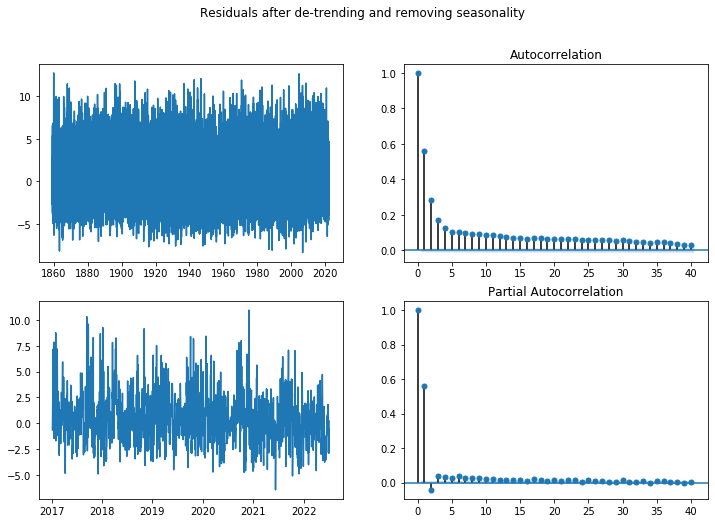

In [20]:
if not isinstance(temp_t.index, pd.DatetimeIndex):
    temp_t.index=temp_t.index.map(dt.datetime.fromordinal)
    
temp_t['res'] = temp_t['T'] - temp_t['model']
temp_t['res'][-5000:].plot(figsize=(12,6))
plt.show()

fig, axs = plt.subplots(2, 2, figsize=(12,8))
fig.suptitle('Residuals after de-trending and removing seasonality')
axs[0,0].plot(temp_t['res'])
axs[1,0].plot(temp_t['res'][-2000:])

plot_acf(temp_t['res'], lags=40, ax=axs[0,1])
plot_pacf(temp_t['res'], lags=40, ax=axs[1,1])
plt.show()

- ### Probability Plot model 

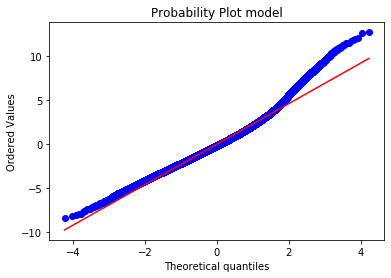

P(Z > 2): 3.59% vs Normal Distibution: 2.28% 
SKEW    : 0.629
KURTOSIS: 4.23


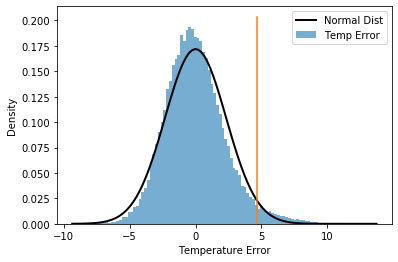

In [21]:
import scipy.stats as stats

stats.probplot(temp_t['res'], dist='norm', plot=plt)
plt.title('Probability Plot model')
plt.show()

mu, std = norm.fit(temp_t['res'])
z = (temp_t['res'] - mu) / std
plt.hist(temp_t['res'], density=True, alpha=0.6, bins=100, label='Temp Error')

xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
data = np.random.randn(100000)

plt.plot(x, p, 'k', linewidth = 2, label='Normal Dist')
plt.plot([std*2, std*2], [0,ymax])

print('P(Z > 2): {:0.3}% vs Normal Distibution: {:0.3}% '.format(len(z[z >= 2])/len(z)*100, (1-norm.cdf(2))*100))
print('SKEW    : {:0.3}'.format(stats.skew(z)))
print('KURTOSIS: {:0.3}'.format(stats.kurtosis(z)+3))
plt.ylabel('Density')
plt.xlabel('Temperature Error')
plt.legend()
plt.show()

### Several issues

- ### String Partial Correlation Identified at lag 1, indicating that we may need some autoregressive model to account for this. Will explain more why this happens when talking about stochastic modeling of daily average temperature. 

- ### Q-Q plot: error distribution is not normally distributed, presence of extreme temperature deviations. 

---
## References

- Mraoua and Bari (2007), Temperature stochastic modeling and weather derivatives: an empirical study with Moroccan data

- Tindall (2006), Weather Derivatives: Pricing and Risk Management Applications 

- Esunge and Njong (2020), Weather Derivatives and the Market Price of Risk